# Module 3 Project:Analyzing Northwind Database

### Outline

- Import packages
- Project Purpose
- Hypothesis test #1

## Import packages

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.formula.api import ols

## Custom files ##
import custom_tools as ct
import MyConn as mc 
import flatiorn_stats as fstats

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Purpose of this Project

In [2]:
my_conn = mc.MyConn(filename='./Northwind_small.sqlite')

Connection established


In [3]:
my_conn.database_tables()

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

## Hypothesis test #1:

_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_

To answer this question, we are going to take a look at the `OrderDetails` table, so that we can pull the data needed to answer the question:



In [4]:
query = """
            SELECT * 
            FROM OrderDetail
            ORDER BY ProductId, Discount;
        """
df_order_details = my_conn.run_query(query, load_df=True)
df_order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10294/1,10294,1,14.4,18,0.0
1,10317/1,10317,1,14.4,20,0.0
2,10354/1,10354,1,14.4,12,0.0
3,10406/1,10406,1,14.4,10,0.0
4,10413/1,10413,1,14.4,24,0.0


In [5]:
df_order_details.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [6]:
my_conn.close_connection()

--------------------------------------------------
--------------- CLOSING CONNECTION ---------------
--------------------------------------------------


In [7]:
df_order_details['is_discount'] = df_order_details.Discount.apply(lambda b: True if b > 0 else False)
df_order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
0,10294/1,10294,1,14.4,18,0.0,False
1,10317/1,10317,1,14.4,20,0.0,False
2,10354/1,10354,1,14.4,12,0.0,False
3,10406/1,10406,1,14.4,10,0.0,False
4,10413/1,10413,1,14.4,24,0.0,False


In [8]:
discounted_values = df_order_details.loc[(df_order_details.is_discount == True)].Quantity.values
non_discounted_values = df_order_details.loc[(df_order_details.is_discount == False)].Quantity.values

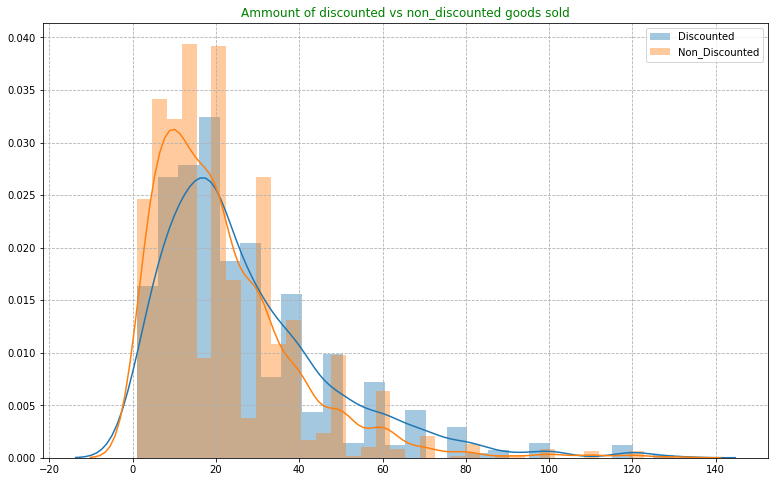

In [9]:
plt.figure(figsize=(13,8))

sns.distplot(a=discounted_values, label='Discounted',)
sns.distplot(a=non_discounted_values, label='Non_Discounted')

plt.title("Ammount of discounted vs non_discounted goods sold", color='green' )
plt.grid(b=True, axis='both', which='major', linestyle='dashed')
plt.legend()
plt.show()

The quantities of the discounted vs non-discounted sales are not normaly distributed.  
From here, we will apply the _Central Limit Theorem_ and take samples of means, to get a more normal distribution

#### _Bootstrap Sampling_

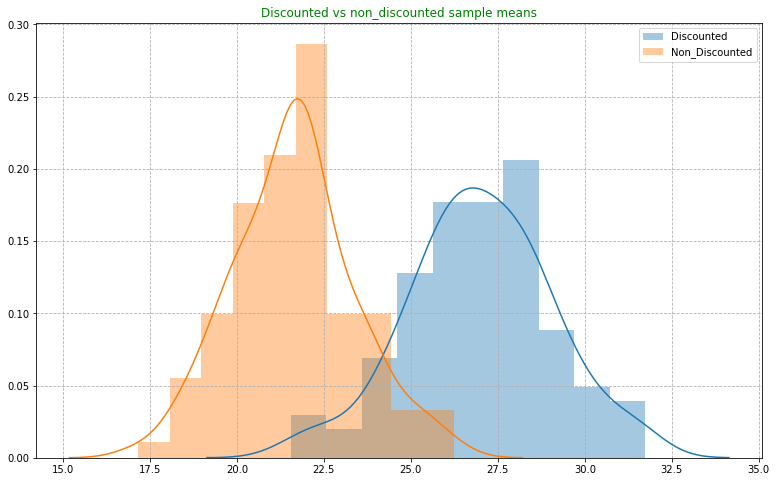

In [10]:
n = 100 #sample size
discounted_sample_means = []
non_discounted_sample_means = []

# Bootstrap simulation for sample population of n
for i in range(n):
    discounted_sample = np.random.choice(discounted_values, size=n)
    non_discounted_sample = np.random.choice(non_discounted_values, size=n)
    
    discounted_sample_means.append(np.mean(discounted_sample))
    non_discounted_sample_means.append(np.mean(non_discounted_sample))

# Recast the sample mean lists as numpy arrays
discounted_sample_means = np.array(discounted_sample_means)
non_discounted_sample_means = np.array(non_discounted_sample_means)

# Plot the sample means of the discounted
plt.figure(figsize=(13,8))

sns.distplot(a=discounted_sample_means, label='Discounted',)
sns.distplot(a=non_discounted_sample_means, label='Non_Discounted')

plt.title("Discounted vs non_discounted sample means", color='green' )
plt.grid(b=True, axis='both', which='major', linestyle='dashed')
plt.legend()
plt.show()

#### Shapiro & Levene tests - Normality & Variance

Now we will apply the Shapiro & Levene tests to see if the sample of means are normalized and to test to see if they have the same variance


In [11]:
# Normality test for disounted sample means
ct.normality_test_shapiro(discounted_sample_means)

p = 0.8625183701515198
Therefore the data is normal


True

In [12]:
# Normality test for non_discounted sample means
ct.normality_test_shapiro(non_discounted_sample_means)

p = 0.739944577217102
Therefore the data is normal


True

In [13]:
# Variance test for disccounted sample means
ct.test_equal_variances(discounted_sample_means, non_discounted_sample_means)

p = 0.08191692191206588
Therefore the data HAS equal variances


True

### T-Test

In [14]:
fstats.p_value_welch_ttest(discounted_sample_means, non_discounted_sample_means, two_sided=True)

0.0

In [15]:
effect_size = fstats.cohen_d(discounted_sample_means, non_discounted_sample_means)
print(f'Effect size: {effect_size}')

Effect size: 2.8334536251092857


## Checking wether or not there is a significant difference bewtween the different levels of discount

In [16]:
df_order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
0,10294/1,10294,1,14.4,18,0.0,False
1,10317/1,10317,1,14.4,20,0.0,False
2,10354/1,10354,1,14.4,12,0.0,False
3,10406/1,10406,1,14.4,10,0.0,False
4,10413/1,10413,1,14.4,24,0.0,False


In [17]:
new_df = df_order_details.groupby('Discount')
new_df[['Quantity']].mean()

,Quantity
Discount,
0.00,21.715262
0.01,2.000000
0.02,2.000000
0.03,1.666667
0.04,1.000000
0.05,28.010811
0.06,2.000000
0.10,25.236994
0.15,28.382166


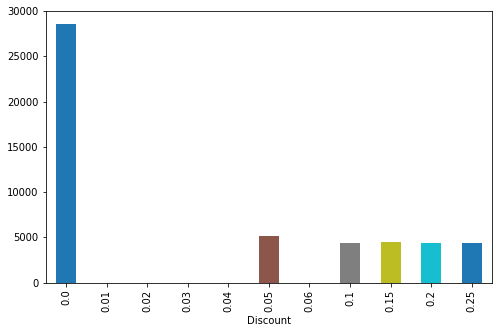

In [18]:
new_df.Quantity.sum().plot.bar(by='Discount', figsize=(8,5))

In [19]:
# Total means of discounts above 0 and less than 0.1
df_order_details.loc[((df_order_details.Discount > 0) & (df_order_details.Discount < 0.1))].Quantity.mean()

26.922279792746114

Since the total mean quantity of the discounts from (0, 0.1) exclusive are not drastically different from the isolated mean of discount 0.5, the other means below 0.01 will be not be used in the calculation.  

These are the discounted rates of `0.01, 0.02, 0.03, 0.04`, and `0.06`.  

* Discount: 0.06 |  Mean: 28.010811
* Discount: (0 => 0.1)  Mean: 26.922279792746114

### Sampling the differnt means using bootstrap

In [20]:
disc_dict = {}
n_min = 100

for k in df_order_details.Discount.unique():
    a = df_order_details.loc[df_order_details.Discount == k].Quantity.values
    if len(a) < n_min:
        continue
    disc_dict[k] = a

### ANOVA Test

In [21]:
## ANOVA Test ##
formula = f'Quantity ~ C(Discount)'
lm = ols(formula, df_order_details).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


Shapiro normality test for Discount 0:
p = 0.8451125621795654
Therefore the data is normal


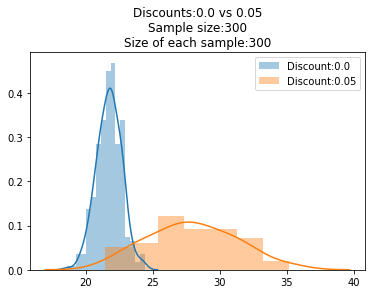

Shapiro normality test test for Discount:0.05
p = 0.8444392085075378
Therefore the data is normal

Variance test of Discount: 0.0 and Discount: 0.05
p = 2.5655083203195557e-35
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
13.337764373550927

p-value of Welch TTest
0.0

Independent ttest scipy.stats
Ttest_indResult(statistic=-13.337764373550927, pvalue=3.751111316391856e-18)

Cohen_D of Discount: 0.0 and Discount: 0.05
4.137751935181661

Statistical Power of the discount given alpha=0.05, effect size:4.137751935181661, nobs1:300 
1.0


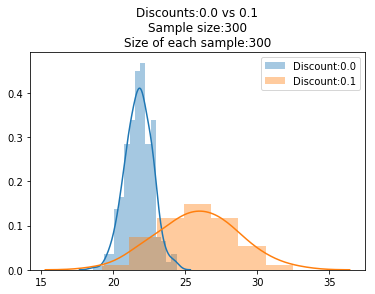

Shapiro normality test test for Discount:0.1
p = 0.9966400265693665
Therefore the data is normal

Variance test of Discount: 0.0 and Discount: 0.1
p = 1.1344422925790994e-25
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
10.51837943570022

p-value of Welch TTest
2.2648549702353193e-14

Independent ttest scipy.stats
Ttest_indResult(statistic=-10.51837943570022, pvalue=2.2644218156712554e-14)

Cohen_D of Discount: 0.0 and Discount: 0.1
3.0581445436455534

Statistical Power of the discount given alpha=0.05, effect size:3.0581445436455534, nobs1:300 
1.0


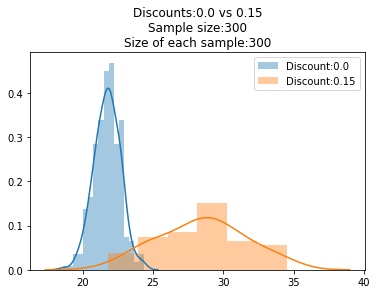

Shapiro normality test test for Discount:0.15
p = 0.8198647499084473
Therefore the data is normal

Variance test of Discount: 0.0 and Discount: 0.15
p = 9.22218107792487e-31
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
15.466779579604967

p-value of Welch TTest
0.0

Independent ttest scipy.stats
Ttest_indResult(statistic=-15.466779579604967, pvalue=8.391457929021401e-21)

Cohen_D of Discount: 0.0 and Discount: 0.15
4.701635558300154

Statistical Power of the discount given alpha=0.05, effect size:4.701635558300154, nobs1:300 
1.0


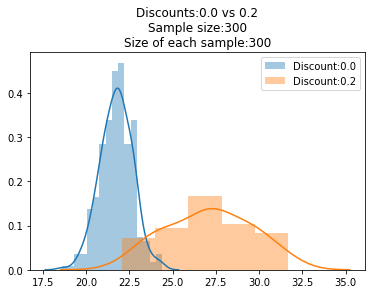

Shapiro normality test test for Discount:0.2
p = 0.36711329221725464
Therefore the data is normal

Variance test of Discount: 0.0 and Discount: 0.2
p = 1.3185182548756594e-23
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
15.260679339037075

p-value of Welch TTest
0.0

Independent ttest scipy.stats
Ttest_indResult(statistic=-15.260679339037075, pvalue=9.851846839683983e-21)

Cohen_D of Discount: 0.0 and Discount: 0.2
4.243764413165871

Statistical Power of the discount given alpha=0.05, effect size:4.243764413165871, nobs1:300 
1.0


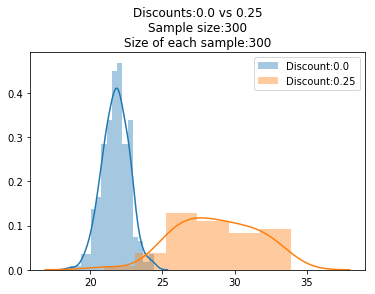

Shapiro normality test test for Discount:0.25
p = 0.4427746832370758
Therefore the data is normal

Variance test of Discount: 0.0 and Discount: 0.25
p = 3.7177339854420966e-31
Therefore the data DOES NOT have equal variances

Welch T-Test of our data:
17.445521820648928

p-value of Welch TTest
0.0

Independent ttest scipy.stats
Ttest_indResult(statistic=-17.445521820648928, pvalue=4.1562137340648405e-23)

Cohen_D of Discount: 0.0 and Discount: 0.25
5.132609873366042

Statistical Power of the discount given alpha=0.05, effect size:5.132609873366042, nobs1:300 
1.0


In [22]:
from itertools import combinations

#Genreate the combinations of the different keys.
# We are only interested in the first 5, since those are the combinations of non_discount vs discount
comb = list(combinations(disc_dict.keys(), 2))

n = sample_size = 300 #set the number of samples equal to the size of each sample
sample_a = ct.bootstrap_sampling(n=n, pop=disc_dict[0], samp_size=sample_size)

print(f'Shapiro normality test for Discount 0:')
ct.normality_test_shapiro(sample_a)
for (a,b) in comb[:5]:
    
    sample_b = ct.bootstrap_sampling(pop=disc_dict[b])
    
    sns.distplot(sample_a, label=f'Discount:{a}') 
    sns.distplot(sample_b, label=f'Discount:{b}')
    
    plt.title(f'Discounts:{a} vs {b}\nSample size:{n}\nSize of each sample:{sample_size}')
    plt.legend()
    plt.show()

    print(f'Shapiro normality test test for Discount:{b}')
    ct.normality_test_shapiro(sample_b)
    
    print(f'\nLevene variance test of Discount: {a} and Discount: {b}')
    is_var_equal = ct.test_equal_variances(sample_a, sample_b)
    
    print(f'\nWelch T-Test of our data:')
    print(fstats.welch_t(sample_a, sample_b))
    
    print(f'\np-value of Welch TTest')
    print(fstats.p_value_welch_ttest(sample_a, sample_b,two_sided=True))
    
    print(f'\nIndependent ttest scipy.stats')
    print(scs.ttest_ind(sample_a, sample_b, equal_var=is_var_equal))
    
    print(f"\nCohen_D of Discount: {a} and Discount: {b}")
    effect_size = abs(fstats.cohen_d(sample_a, sample_b))
    print(effect_size)
    
    print(f'\nStatistical Power of the discount given alpha=0.05, effect size:{effect_size}, nobs1:{n} ')
    print(tt_ind_solve_power(effect_size=effect_size, nobs1=n, alpha=0.05))

Based on the findings, Discount does have a significant effect on the quantities sold.

### At what level of discounts is there that our sales are significantly impacted?

Based on the information from our findings, there is not a siginificant difference of sales between different levels of discounts 

What is the effect size telling us about our finding?

# Conclusion

Based on the statistics and the test received from the data, discounts are significant in determining the quantity of goods sold.  However, the level of discount does not seem to be different amongst the different discounts. 

To better capture the results of the test, discounts levels without sufficient data were removed from our analysis.

The following discounts were removed:

0.01, 0.02, 0.03, 0.04, & 0.06

The higher discounts has an advantage over the lower ones that we did compare, but due to the large magnitutde of the p-test ran, the difference is slighty greater due to associated effect sizes.

My recommendation to the company would be to sell more of their goods at the discount level of 0.05.  Although the discounts at the higher levels did do slightly better than that of 0.05, the company's sales would benefit more by selling at the discount of 0.05.  I also recommend incorporating the higher discount levels of 0.10 & higher as an incentive for client loyalty and to encourage more purchases, with the hope of possibly making a purchase at a higher discount level.